### Filtrando i dati

devo leggere tutt .csv e salvare solamente la 'close' di ogni csv

In [3]:
import cudf as cf
from bollinger_filter import backtest_bollinger_strategy

eurgbp = cf.read_csv('/home/edoardo/Desktop/python_dir/data/eurgbp_24_25.csv')
train_size = 0.6
eurgbp_train = eurgbp.iloc[:int(len(eurgbp)*train_size)] #selects the first slice of data as training set
eurgbp_test = eurgbp.iloc[int(len(eurgbp)*train_size):] #selects the second slice of data as test set


#audnzd = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/audnzd-m1-bid-2015-01-01-2025-01-31T15:24.csv')
#eurchf = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurchf-m1-bid-2024-01-01-2025-01-28.csv')

<Axes: title={'center': 'Bollinger Strategy close at middle band'}, xlabel='timestamp'>

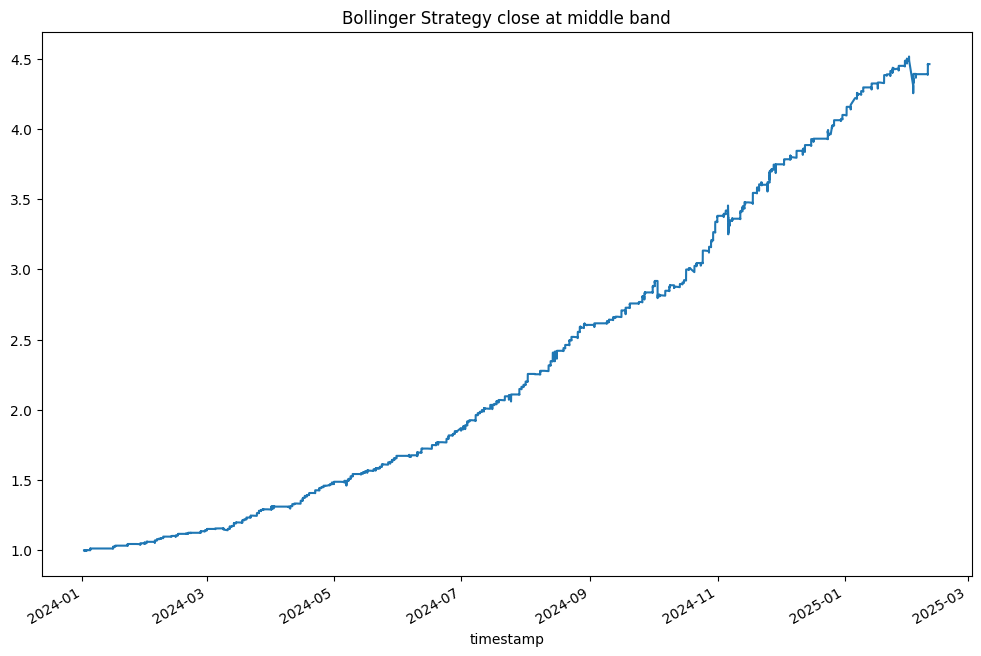

In [4]:
## FUNCTION USER

result = backtest_bollinger_strategy(data=eurgbp, lookback=180, sdev=4, return_series=True,
                                     fee_percentage=0.01, filter=2)

result = result.to_pandas()
result.plot(figsize=(12, 8), title='Bollinger Strategy close at middle band')

### Alternative data from ForexHistData.com

In [ ]:
#HERE I TEST WITH ALTERNATIVE DATA FROM FOREXSHISTDATA.COM

from bollinger_filter import backtest_bollinger_strategy
import cudf as cf
test = cf.read_parquet('/home/edoardocame/Desktop/python_dir/data/eurgbp_merged.parquet')
test.sort_index(inplace=True)
test.reset_index(inplace=True)
test.columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume']
test.tail()

### Ottimizzazione dei parametri con pandas/polars
Devo ottimizzare i parametri dei backtest per poi testarli nel portafoglio combinato

In [ ]:
#Questa è la via pandas, susseguentemente farò quella con polars;
#ci mettono lo stesso identico tempo in termini di velocità.

import pandas as pd
import time as t

my_combinations = pd.read_csv('/home/edoardo/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/Bollinger Bands Strategy/my_combinations.csv', index_col=0)

start_time = t.time()

####################
my_combinations['result'] = 0
def apply_strategy(row):
    result = backtest_bollinger_strategy(data=eurgbp_train, lookback=row['lookback'], 
                                         sdev=row['sdev'], leverage=10, filter=row['filter'], fee_percentage=0.01)
    print(f"Processed lookback: {row['lookback']}, sdev: {row['sdev']}, result: {result}, filter: {row['filter']}")
    return result

my_combinations['result'] = my_combinations.apply(apply_strategy, axis=1)
####################

end_time = t.time() - start_time

print(f"Time elapsed: {end_time}")

In [ ]:
my_combinations.to_csv('/home/edoardo/Desktop/python_dir/data/my_combinations_results.csv')

### Analisi dei migliori parametri
Qui analizzo quali sono i migliori parametri trovati per EUR/GBP;
Poi farò lo stesso con le altre coppie.

In [ ]:
import cudf as cf
my_combinations = cf.read_csv('/home/edoardo/Desktop/python_dir/data/my_combinations_results.csv', index_col=0)
my_combinations.groupby('filter').mean()['result']

#### Try to find patterns:

Ho notato che gli stessi parametri (lookback 60, sdev 4/5) funzionano sia prima del 2007 in eurgbp sia dopo il 2022. Quando funzionano, vanno avanti per anni con drawdown minimi. Il prossimo passo è backtestare questa strategia su più coppie in modo da vedere se anche nelle altre valute è cosi o meno.
Devo:
1. Raggruppare la funzione di ottimizzazione in uno script.py in modo da renderla meno ingombrante
2. Testarla su ampi orizzonti temporali su altre coppie di valute
3. Provarla con gli stop loss e take profit per vedere se aiutano nel tagliare i DDs.
4. Controllare la mappa delle combinazioni siccome ci sono differenze ABISSALI con alcuni parametri e i rispettivi filtri della stagionalità;


```
filter
2    3618.977340
1      88.894749
0     629.042742
Name: result, dtype: float64
```

In [ ]:
import cudf as cf
import bollinger_filter
eurgbp = cf.read_csv('/home/edoardocame/Desktop/python_dir/data/eurgbp-m1-bid-2003-08-03T21-2025-02-04T13:38.csv',
                     index_col=0)
eurgbp_temp = eurgbp[eurgbp.index < '2007-01-01']
#eurgbp_temp = eurgbp[eurgbp.index > '2022-01-01'] #If you try this time window, the SAME parameters work out too!

In [ ]:
from bollinger_filter import backtest_bollinger_strategy
import cudf as cf


esempio = backtest_bollinger_strategy(data = eurgbp_temp, lookback= 60, sdev= 5, 
                                      fee_percentage=0.005, return_series=True, leverage=10, filter=0)

#print(esempio)
import matplotlib.pyplot as plt
esempio.dropna(inplace=True)
esempio = esempio.to_pandas()
esempio.plot(figsize=(20, 8))   

Qui voglio vedere se i filtri hanno avuto effetto;

In [ ]:
import cudf as cf
df = cf.read_csv('/home/edoardocame/Desktop/python_dir/PythonMiniTutorials/trading strategies/MyOwnBacktester/transition to cuDF/my_combinations_results.csv')
df = df.dropna()
#Voglio vedere se la media dei risultati varia significativamente in base al filtro;
#Se non varia, posso escluderlo dalla strategia.
df.groupby('filter')['result'].mean()

#### Plot 3d dei risultati
Esempio di ottimizzazione con eur/gbp: mostriamo un grafico 3d dei risultati;

In [ ]:
import pandas as pd
import plotly.graph_objects as go

my_combinations = pd.read_csv('/home/edoardocame/Desktop/python_dir/transition to cuDF/my_combinations_results_leverage.csv')

#Subset the data keeping only sdevs between 4 and 10
my_combinations = my_combinations[(my_combinations['sdev'] > 3) & (my_combinations['sdev'] < 10)]


z = my_combinations['result'].values
x = my_combinations['sdev'].values
y = my_combinations['lookback'].values

fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=12, color=z, colorscale='Viridis', opacity=0.8))])
fig.update_layout(scene = dict(xaxis_title='Standard Deviation', yaxis_title='Lookback', zaxis_title='Result'))
fig.show()